# **Fraud Detection Project**

**Objective**: Detect fraudulent transactions in a highly imbalanced, real world [dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) (0.17% fraud), aiming at least 0.9 recall.

**Approach:**

- Techniques Used: Applied Random Forest, CatBoost, XGBoost, and Neural Network models, along with SMOTE and Random Undersampling to address class imbalance.

- Data Processing: Included data cleaning, EDA, and feature engineering.

- Evaluation: Focused on PR-AUC and F2-Score, and Cost with a focus on minimizing false negatives (missed frauds).

**Results:**

- XGBoost achieved the highest F2 Score (optimal balance between precision and recall) and **0.79 PR-AUC** (CatBoost gets 0.81 PR-AUC but cost more), with the lowest financial impact of errors.

- Key Insight: Most fraud transactions occurred during low-alert periods (evenings/afternoons). V14 and V4 are most important features for fraud detection models.

**Tools**: scikit-learn, CatBoost, XGBoost, Random Forest, TensorFlow/Keras.

In [ ]:
!pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, matthews_corrcoef,
    precision_recall_curve, average_precision_score, ConfusionMatrixDisplay,
    )
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
import os
import shap
import warnings
warnings.filterwarnings("ignore")
# Set global random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
pd.options.display.max_columns = None

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
df = pd.read_csv(os.path.join(path, "creditcard.csv"))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#**I. Data Cleaning**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

There is no null value in this dataset

In [ ]:
# Check for duplicate values
df.duplicated().sum()

np.int64(1081)

In [ ]:
# Get a look at duplicated rows
df[df.duplicated(keep=False) == True].head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
220,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,0.158497,-1.224951,1.314705,0.304412,-0.290218,-2.014548,-0.772801,0.696761,0.017914,2.177250,-0.276207,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0
221,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,0.158497,-1.224951,1.314705,0.304412,-0.290218,-2.014548,-0.772801,0.696761,0.017914,2.177250,-0.276207,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0


Those duplicated transactions happend at the same time, and have the same feature values. I will keep only 1 transaction for each.

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(0)

#**II. EDA**

In [ ]:
# Feature engineering
df['Hour_in_day'] = (df['Time'] // 3600) % 24  # 0-23 hours

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour_in_day
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,0.000202,-0.000715,0.000603,0.000252,0.001043,0.001162,0.000170,0.001515,-0.000264,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667,14.045646
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,1.018720,0.994674,0.995430,0.952215,0.914894,0.873696,0.842507,0.837378,0.813379,0.769984,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796,5.834817
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,-0.761649,-0.406198,-0.647862,-0.425732,-0.581452,-0.466860,-0.483928,-0.498014,-0.456289,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000,10.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,-0.032306,0.139072,-0.012927,0.050209,0.049299,0.067119,-0.065867,-0.002142,0.003367,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000,15.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,0.739579,0.616976,0.663178,0.492336,0.650104,0.523512,0.398972,0.501956,0.458508,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000,19.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000,23.000000


While most features cluster around 0, there are some extreme outliers.

**Distribution of Class**

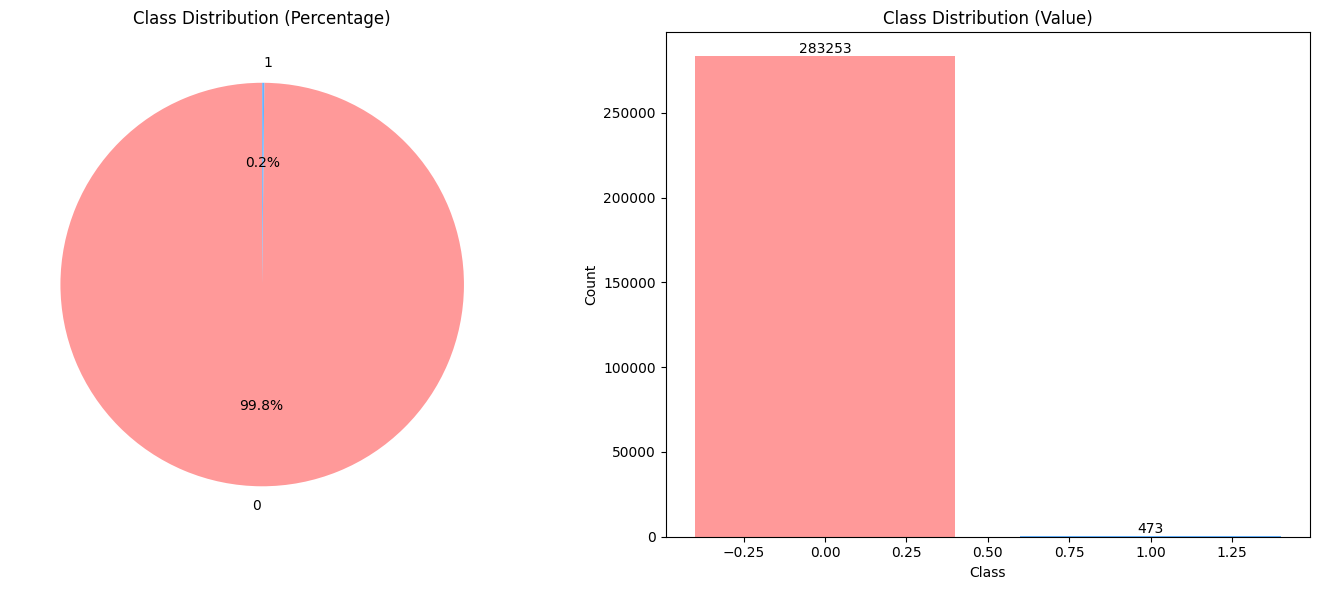

In [ ]:
# See the distribution of Class
class_counts = df['Class'].value_counts()

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
axes[0].set_title("Class Distribution (Percentage)")

axes[1].bar(class_counts.index, class_counts, color=['#ff9999','#66b3ff'])
axes[1].set_title("Class Distribution (Value)")
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Adding annotations for bar chart
for i, v in enumerate(class_counts):
    axes[1].text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

This is a highly imbalanced dataset.

**Distribution of Class by Hour**

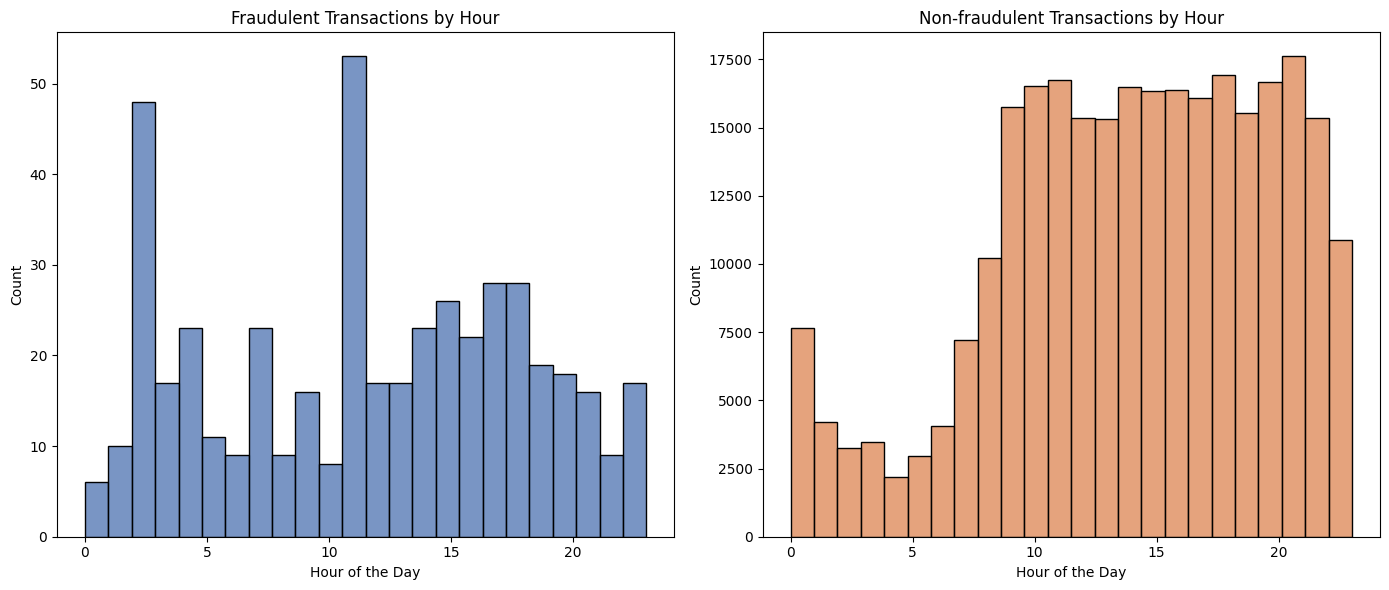

In [ ]:
# Fraud distribution by Hour
df_fraud = df[df['Class'] == 1]
df_non_fraud = df[df['Class'] == 0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.color_palette("deep")

colors = sns.color_palette("deep")
sns.histplot(data=df_fraud, x='Hour_in_day', bins=24, color=colors[0], ax=axes[0], kde=False)
axes[0].set_title('Fraudulent Transactions by Hour')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Count')

sns.histplot(data=df_non_fraud, x='Hour_in_day', bins=24, color=colors[1], ax=axes[1], kde=False)
axes[1].set_title('Non-fraudulent Transactions by Hour')
axes[1].set_xlabel('Hour of the Day')

plt.tight_layout()
plt.show()

There is a distinct behavior of fraud and non-fraud transaction.
- Non-fraud: usually happen during 7h-24h which is the time people are awaked and participate in transaction normally.
- Fraud: happens most at 3h and 12h which are the time people are slept. There are also a lot of fraud transaction in 18-19h which are the time people cooke dinner, take care of children, or on the way back home

---> I assume that the hackers take advantage of the time of the day when users are not alert to get money

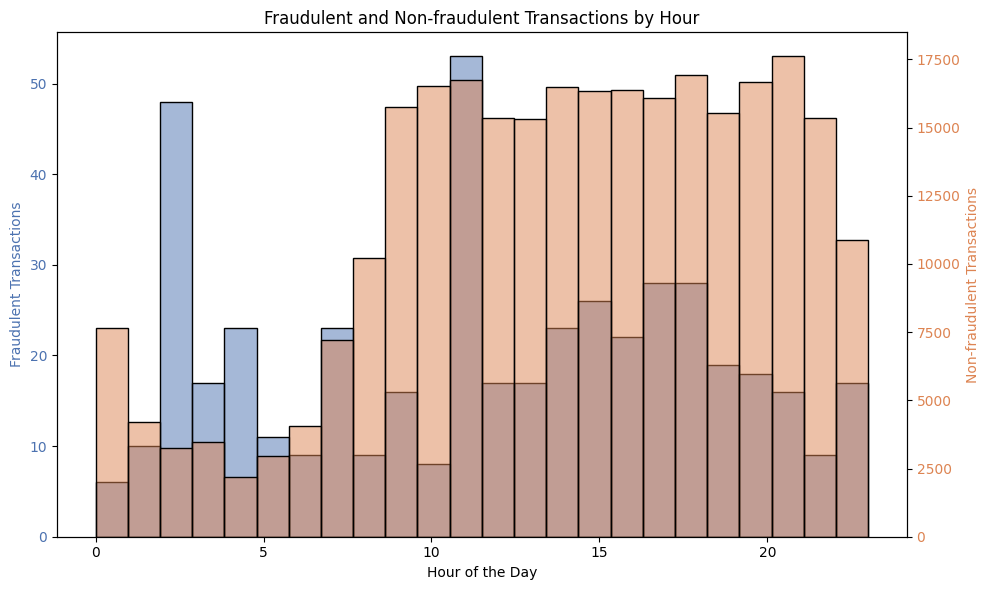

In [ ]:
# A closer look at the difference in distribution
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot fraudulent transactions by Hour on the first y-axis
sns.histplot(data=df_fraud, x='Hour_in_day', bins=24, color=colors[0], ax=ax1, alpha=0.5)
ax1.set_title('Fraudulent and Non-fraudulent Transactions by Hour')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Fraudulent Transactions', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Create a second y-axis to plot non-fraudulent transactions
ax2 = ax1.twinx()
sns.histplot(data=df_non_fraud, x='Hour_in_day', bins=24, color=colors[1], ax=ax2, alpha=0.5)
ax2.set_ylabel('Non-fraudulent Transactions', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

plt.tight_layout()
plt.show()

**Distribution of Amount by Class**

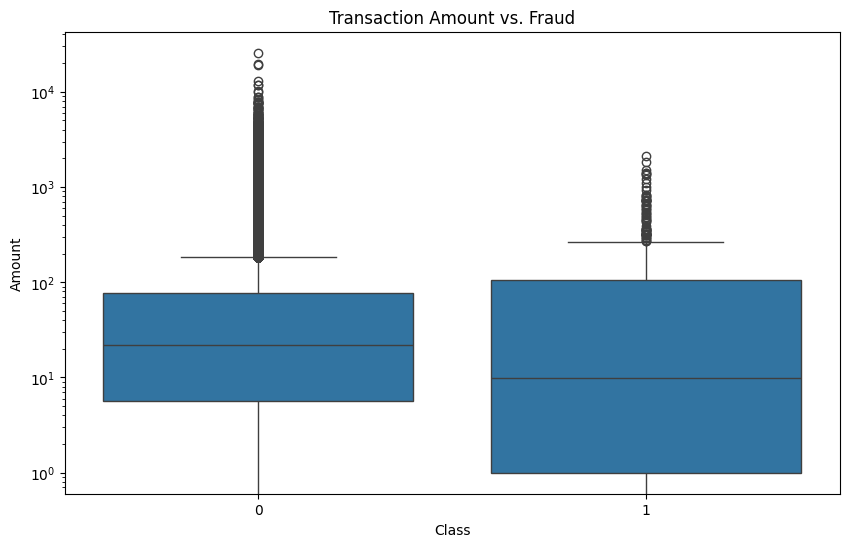

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.yscale('log')
plt.title('Transaction Amount vs. Fraud')
plt.show()

The non-fraud transaction has more extreme amount values, and higher median than fraud transaction.

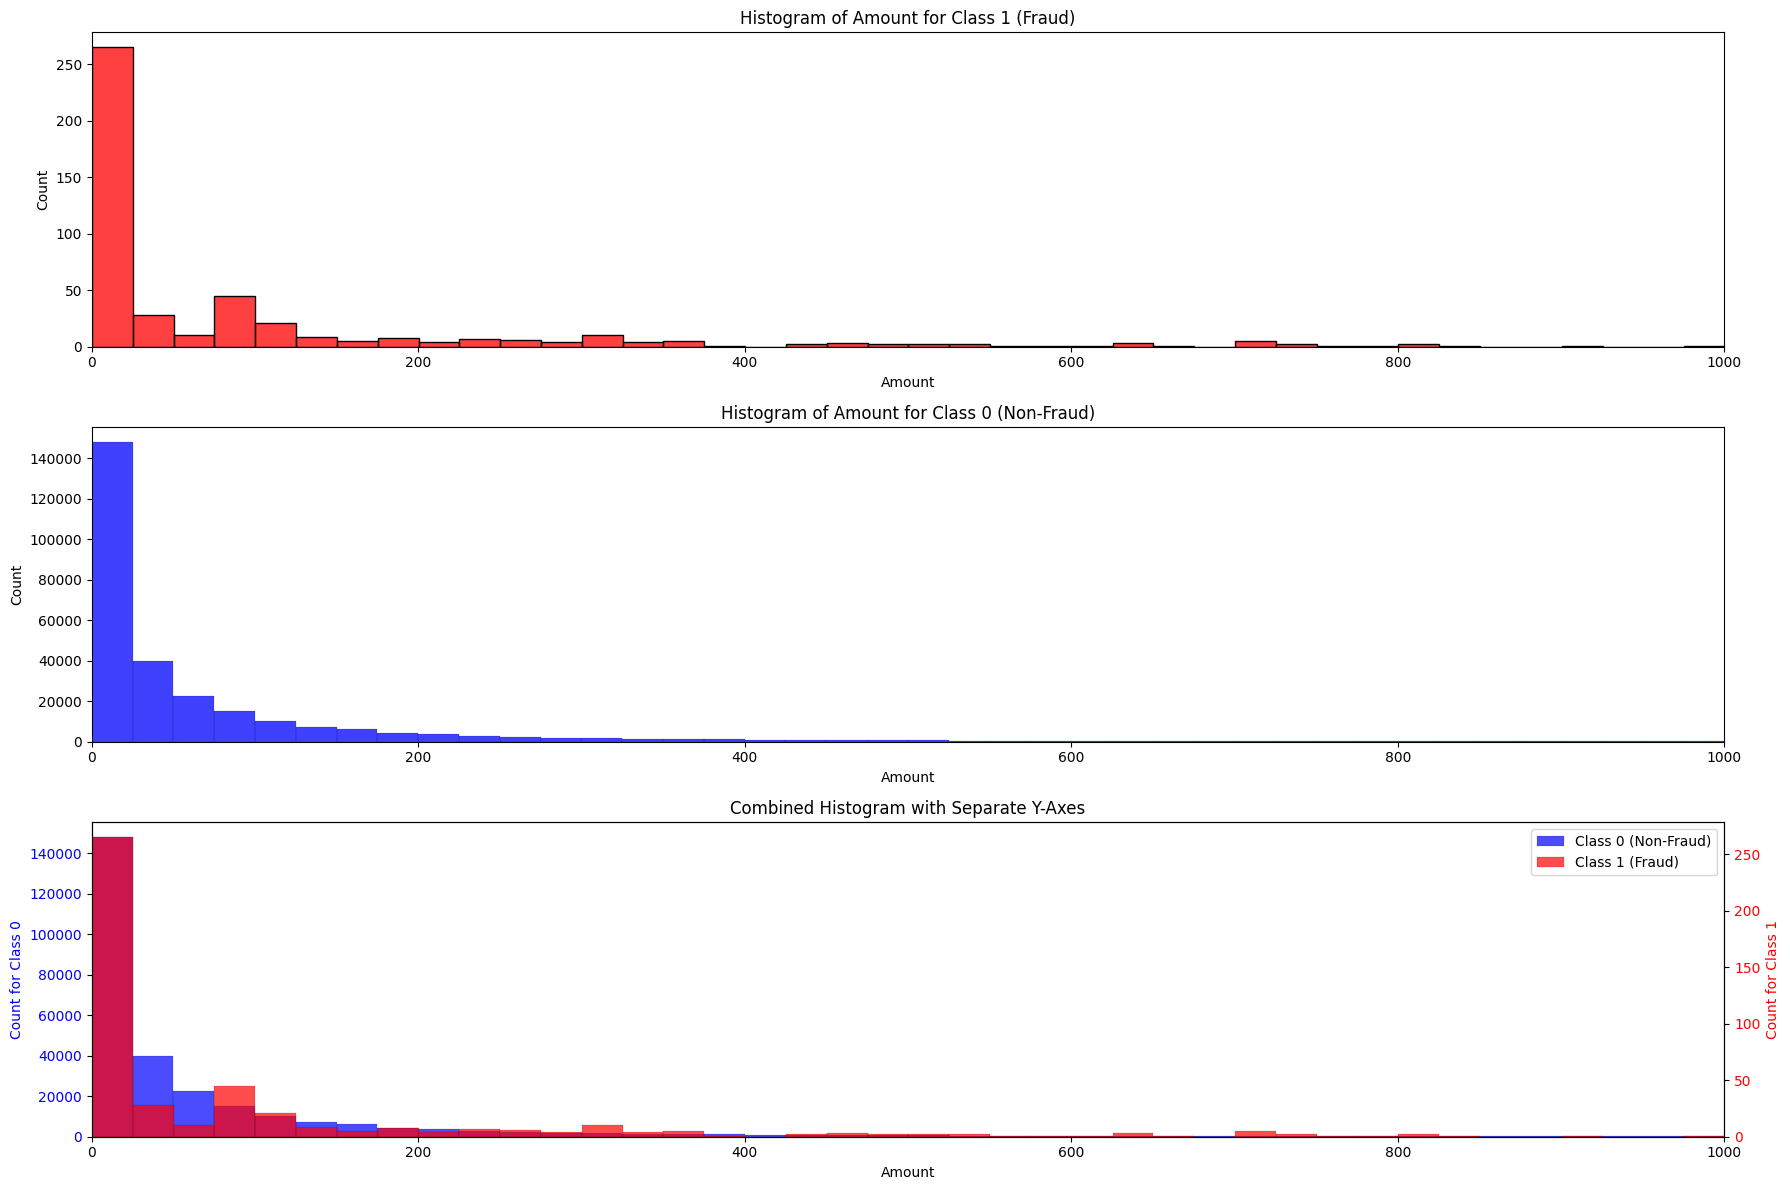

In [ ]:
# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# fraudulent transactions
sns.histplot(df_fraud['Amount'], binwidth=25, color='red', ax=axes[0], kde=False)
axes[0].set_title('Histogram of Amount for Class 1 (Fraud)')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Count')
axes[0].set_xlim(0, 1000) # Actual range is from 0 to 2000

# non-fraudulent transactions
sns.histplot(df_non_fraud['Amount'], binwidth=25, color='blue', ax=axes[1], kde=False)
axes[1].set_title('Histogram of Amount for Class 0 (Non-Fraud)')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Count')
axes[1].set_xlim(0, 1000) # Actual range is from 0 to 25000

#Combined histogram with twin y-axes
ax2 = axes[2]

# Plot Class 0 on left y-axis
hist_class0 = sns.histplot(df_non_fraud['Amount'], binwidth=25, color='blue',
                          ax=ax2, kde=False, alpha=0.7, label='Class 0 (Non-Fraud)')
ax2.set_ylabel('Count for Class 0', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Create twin axis for Class 1
ax3 = ax2.twinx()

# Plot Class 1 on right y-axis
hist_class1 = sns.histplot(df_fraud['Amount'], binwidth=25, color='red',
                          ax=ax3, kde=False, alpha=0.7, label='Class 1 (Fraud)')
ax3.set_ylabel('Count for Class 1', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Combine legends from both axes
handles = [hist_class0.containers[0][0], hist_class1.containers[0][0]]
labels = ['Class 0 (Non-Fraud)', 'Class 1 (Fraud)']
ax2.legend(handles=handles, labels=labels, loc='upper right')

# Common settings for combined plot
ax2.set_xlabel('Amount')
ax2.set_title('Combined Histogram with Separate Y-Axes')
ax2.set_xlim(0, 1000)

plt.tight_layout()
plt.show()

Note: Actual range of Amount of Class 1 is 0 to 2000, of Class to is 0 to 25000. I limit the y axis from 0 to 1000 so that we can see the pattern more clearly.

**Features Distribution**

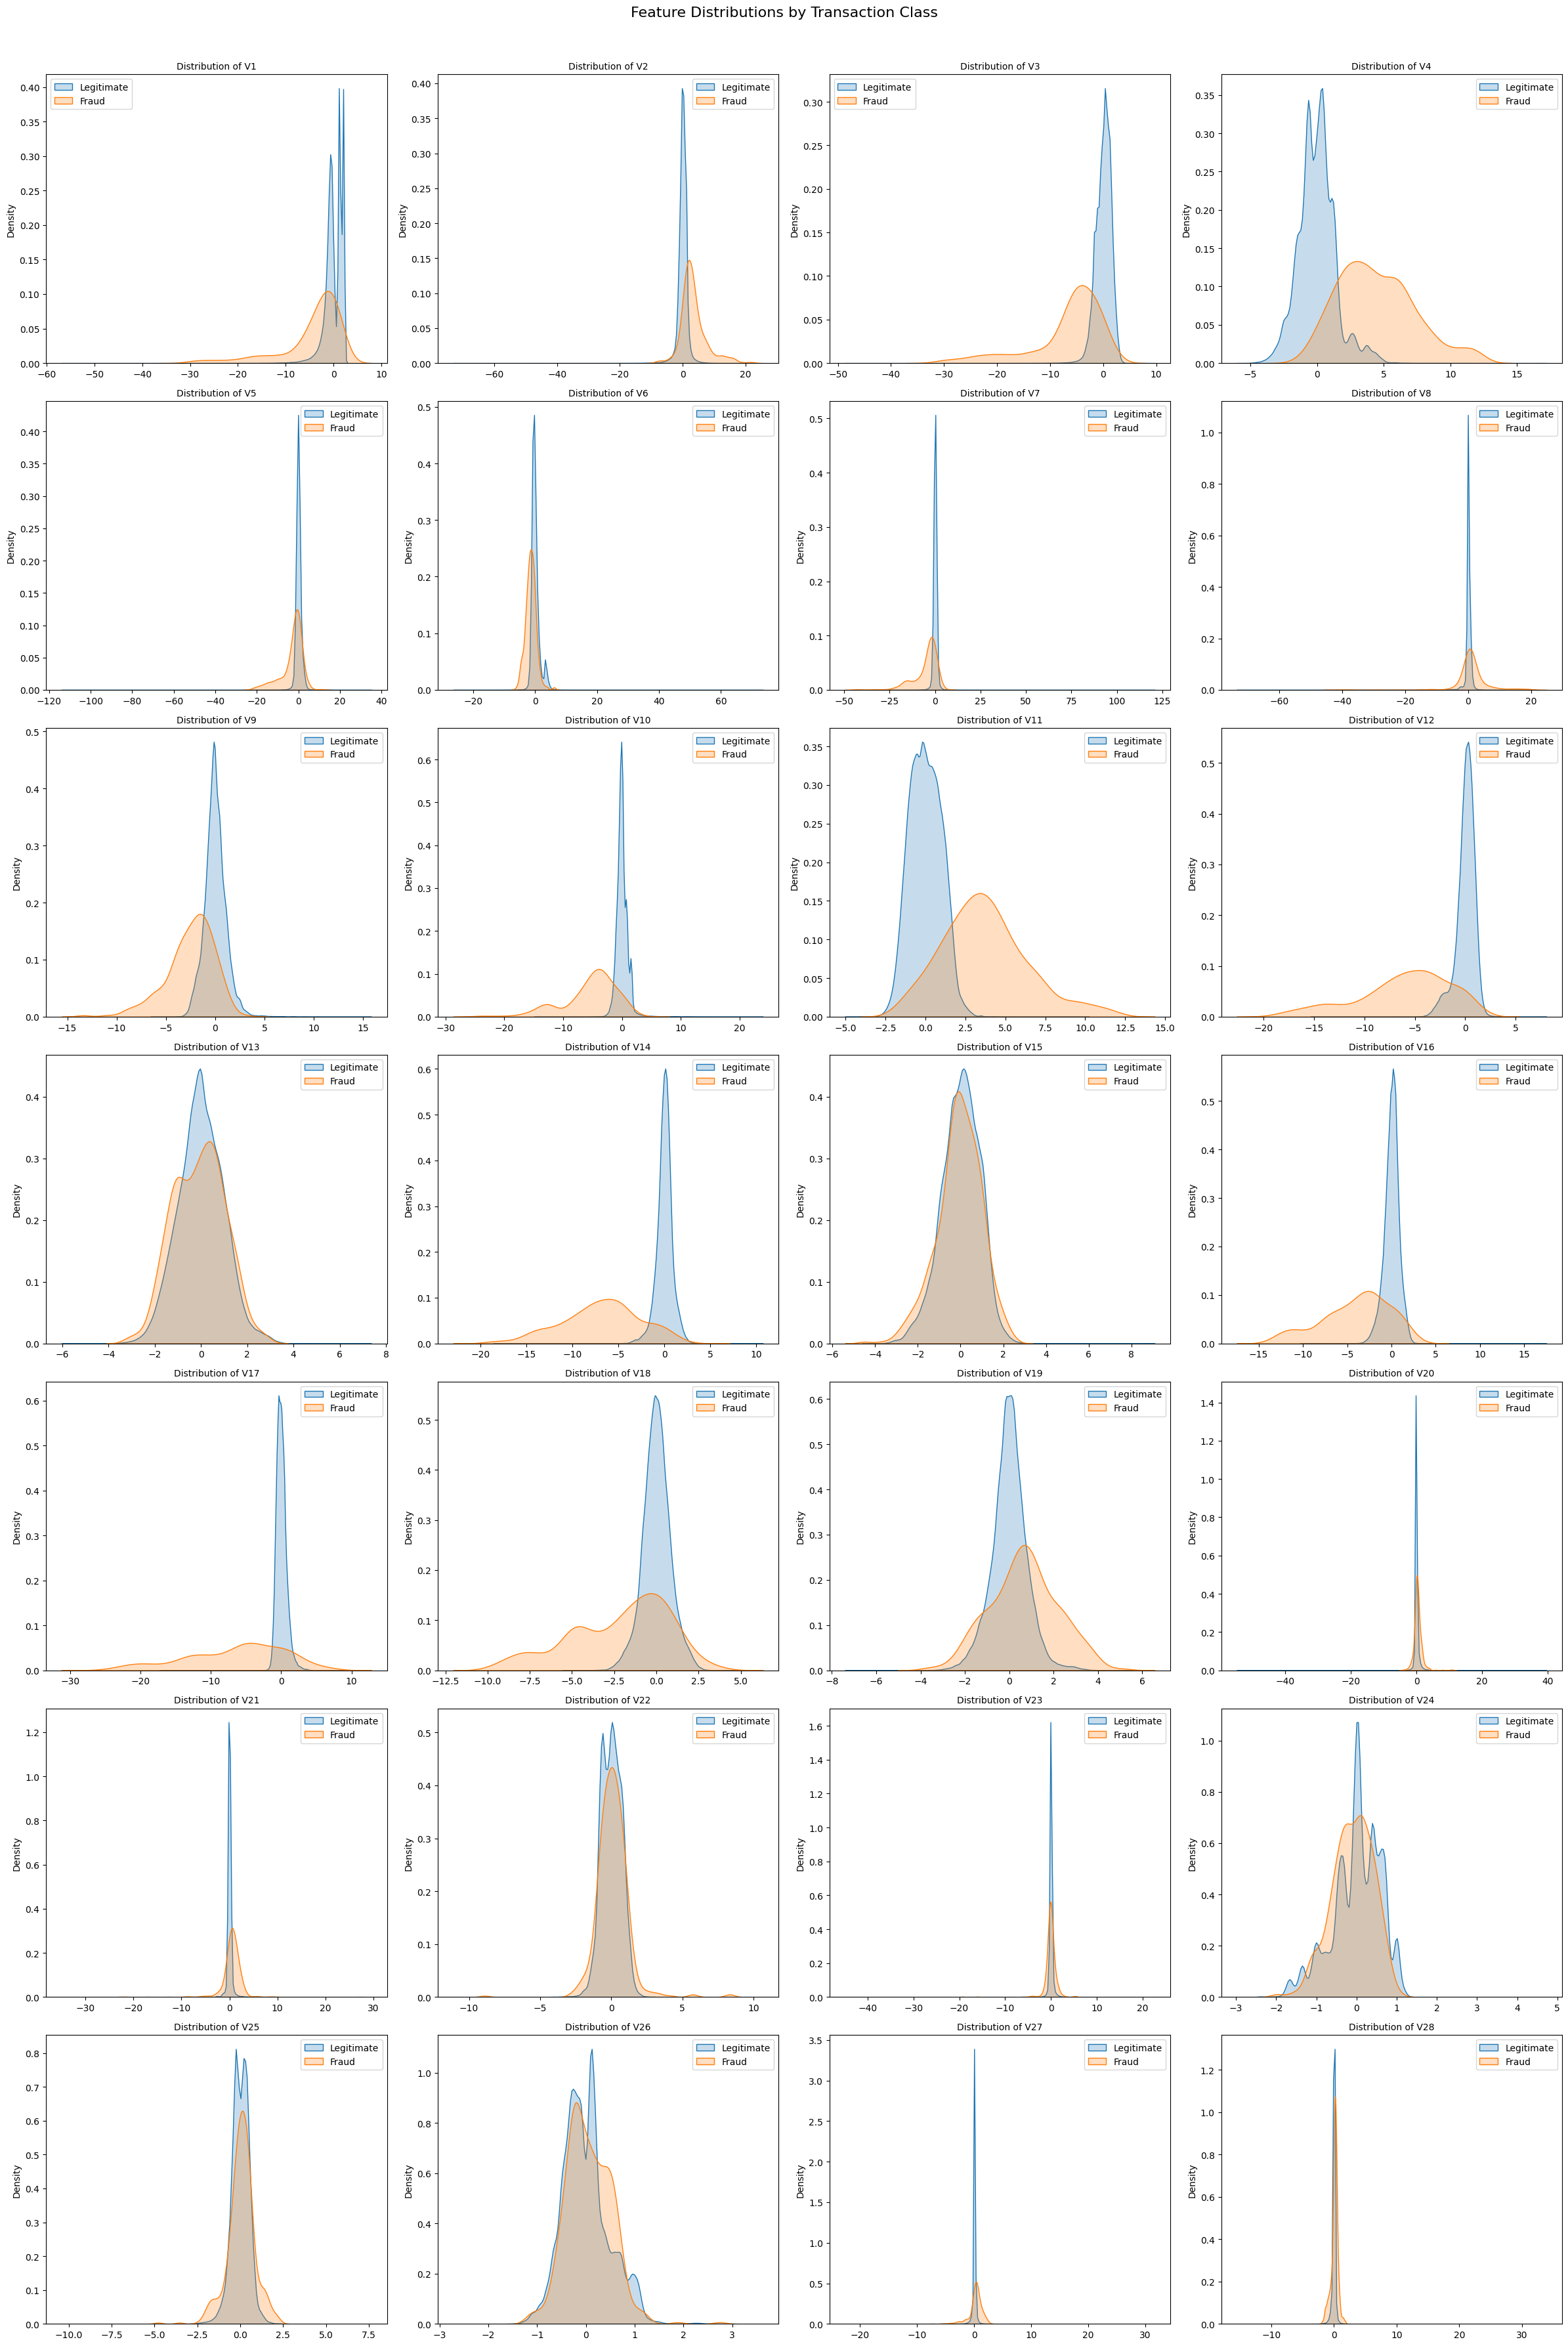

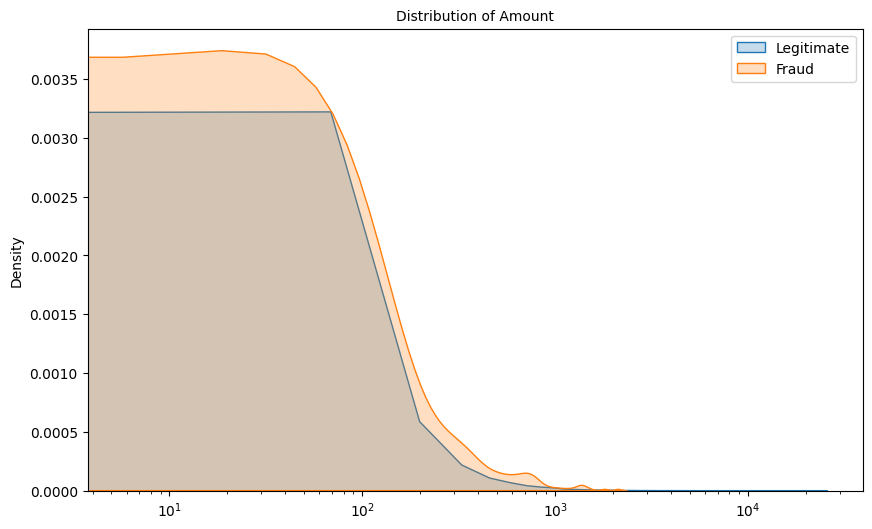

In [ ]:
# Create subplot for distribution of each features
fig, axes = plt.subplots(7, 4, figsize=(24, 35))
axes = axes.ravel()

# Plotting function for subplots
def plot_distribution(feature, ax, log_scale=False):
    sns.kdeplot(df[df['Class'] == 0][feature],
                label='Legitimate', fill=True, ax=ax)
    sns.kdeplot(df[df['Class'] == 1][feature],
                label='Fraud', fill=True, ax=ax)
    if log_scale:
        ax.set_xscale('log')
    ax.set_title(f'Distribution of {feature}', fontsize=10)
    ax.set_xlabel('')
    ax.legend()

# Plot V1-V28 features
for i, col in enumerate(df.columns[1:29]):  # Assuming V1-V28 are columns 1-28
    plot_distribution(col, ax=axes[i])

# Remove any empty subplots
for j in range(len(df.columns[1:29]), 7*4):
    fig.delaxes(axes[j])

# Adjust layout and add main title
plt.tight_layout()
fig.suptitle('Feature Distributions by Transaction Class', fontsize=16, y=1.02)
plt.show()

# Plot Amount separately with log scale
plt.figure(figsize=(10, 6))
plot_distribution('Amount', ax=plt.gca(), log_scale=True)

For most of features, features of fraud transaction tend to be more spread, while features of non-fraud transaction tend to be more concentrated.

**Check if frauds cluster in PCA space**

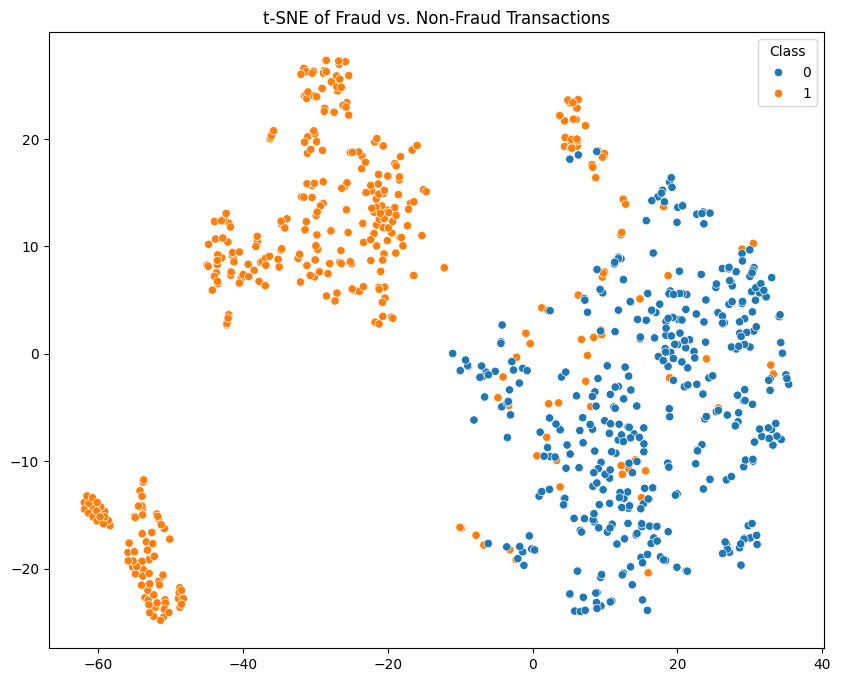

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE

# Subsample data for speed
fraud_sample = df[df['Class'] == 1].sample(400, random_state=RANDOM_STATE)
non_fraud_sample = df[df['Class'] == 0].sample(400, random_state=RANDOM_STATE)
sample = pd.concat([fraud_sample, non_fraud_sample])

# Normalize Time and Amount for better convergence
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
sample['Amount'] = rob_scaler.fit_transform(sample['Amount'].values.reshape(-1,1))
sample['Time'] = rob_scaler.fit_transform(sample['Time'].values.reshape(-1,1))

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
tsne_results = tsne.fit_transform(sample.iloc[:, 0:30])

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=sample['Class'])
plt.title('t-SNE of Fraud vs. Non-Fraud Transactions')
plt.show()

TNSE clusters fraud and non-fraud well with just a small data

---> This is an indication that the ML models can separate between two classes well.

**Fraud Rate over Time**

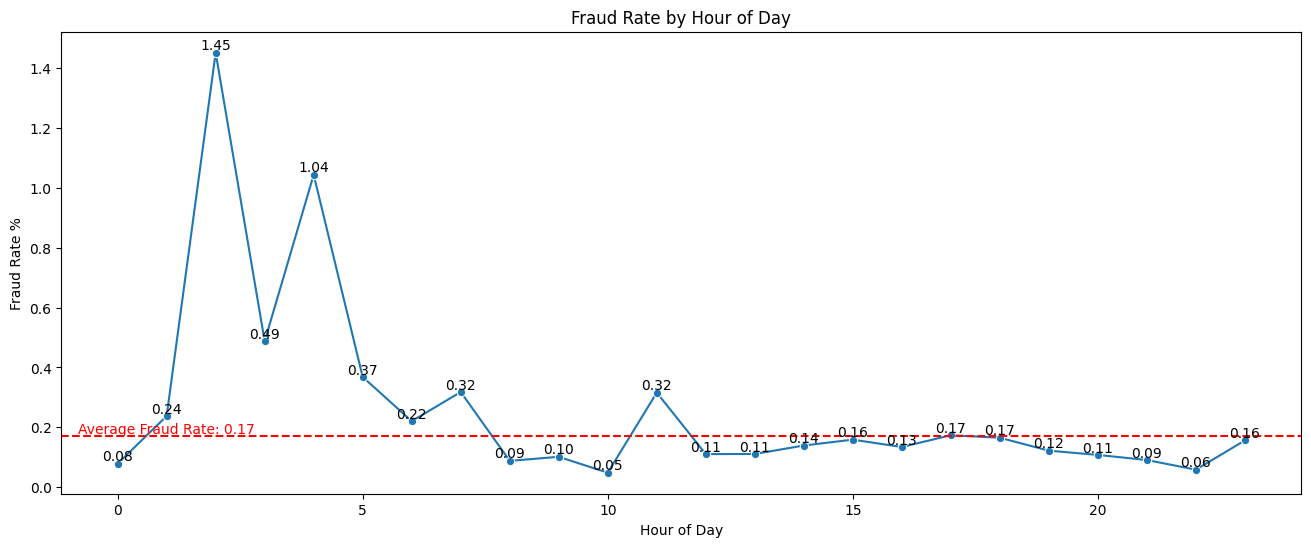

In [ ]:
# Fraud rate by hour
fraud_by_hour = df.groupby('Hour_in_day')['Class'].mean().reset_index()
fraud_by_hour["Class"] = fraud_by_hour["Class"]*100 # Convert to percentage
plt.figure(figsize=(16, 6))
sns.lineplot(x='Hour_in_day', y='Class', data=fraud_by_hour, marker='o')

# Add annotations
for i in range(fraud_by_hour.shape[0]):
    plt.text(fraud_by_hour['Hour_in_day'][i], fraud_by_hour['Class'][i],
             f'{fraud_by_hour["Class"][i]:.2f}',
             horizontalalignment='center',
             verticalalignment='bottom',
             fontsize=10, color='black')
avg_fraud_rate = round(df["Class"].mean()*100, 2)
plt.axhline(y=avg_fraud_rate, color='r', linestyle='--')
plt.text(1, avg_fraud_rate + 0.0001, f"Average Fraud Rate: {avg_fraud_rate}", color='red', va='bottom', ha='center')

plt.title('Fraud Rate by Hour of Day')
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate %")
plt.show()

- We sell the Fraud Rate % is highest between 1am - 6am which is the time people are slept and do not alert to react fraud transaction. The rate is high again at 11-12am which is the time people take a nap in the afternoon.

- During the day, the rate is low when people are awaked

**Fraud correlation with PCA components**

For this correlation analysis, I will use the balanced dataset that I created above called "sample" (in the part using TSNE). Because highly imbalanced dataset may affect correlation.

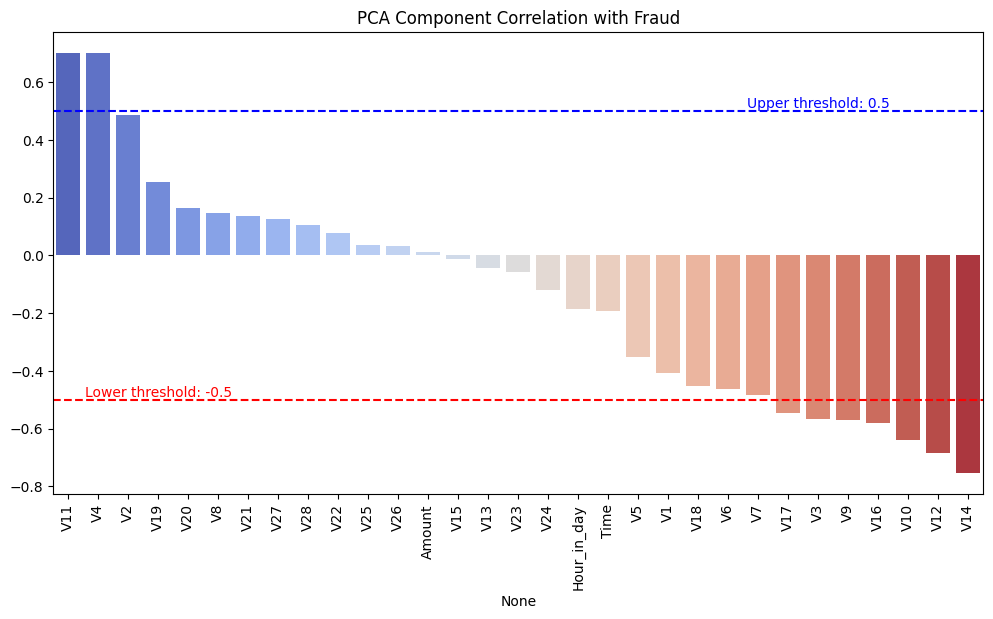

In [ ]:
# Fraud correlation with PCA components
fraud_corr = sample.corr()['Class'].sort_values(ascending=False)
fraud_corr = fraud_corr.drop(['Class'])

plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_corr.index, y=fraud_corr.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('PCA Component Correlation with Fraud')

plt.axhline(y=0.5, color="blue", linestyle="dashed")
plt.text(25, 0.5 + 0.0001, "Upper threshold: 0.5", color='blue', va='bottom', ha='center')
plt.axhline(y=-0.5, color="red", linestyle="dashed")
plt.text(3, -0.5 + 0.0001, "Lower threshold: -0.5", color='red', va='bottom', ha='center')

plt.show()

Significant Correlations:
- Negative Correlation: V17, V3, V9, V16, V10, V12, V14. The lower these values, the more likely the transaction are fraud
- Positive Correlation: V11, V4. The higher these values, the more likely the transaction are fraud

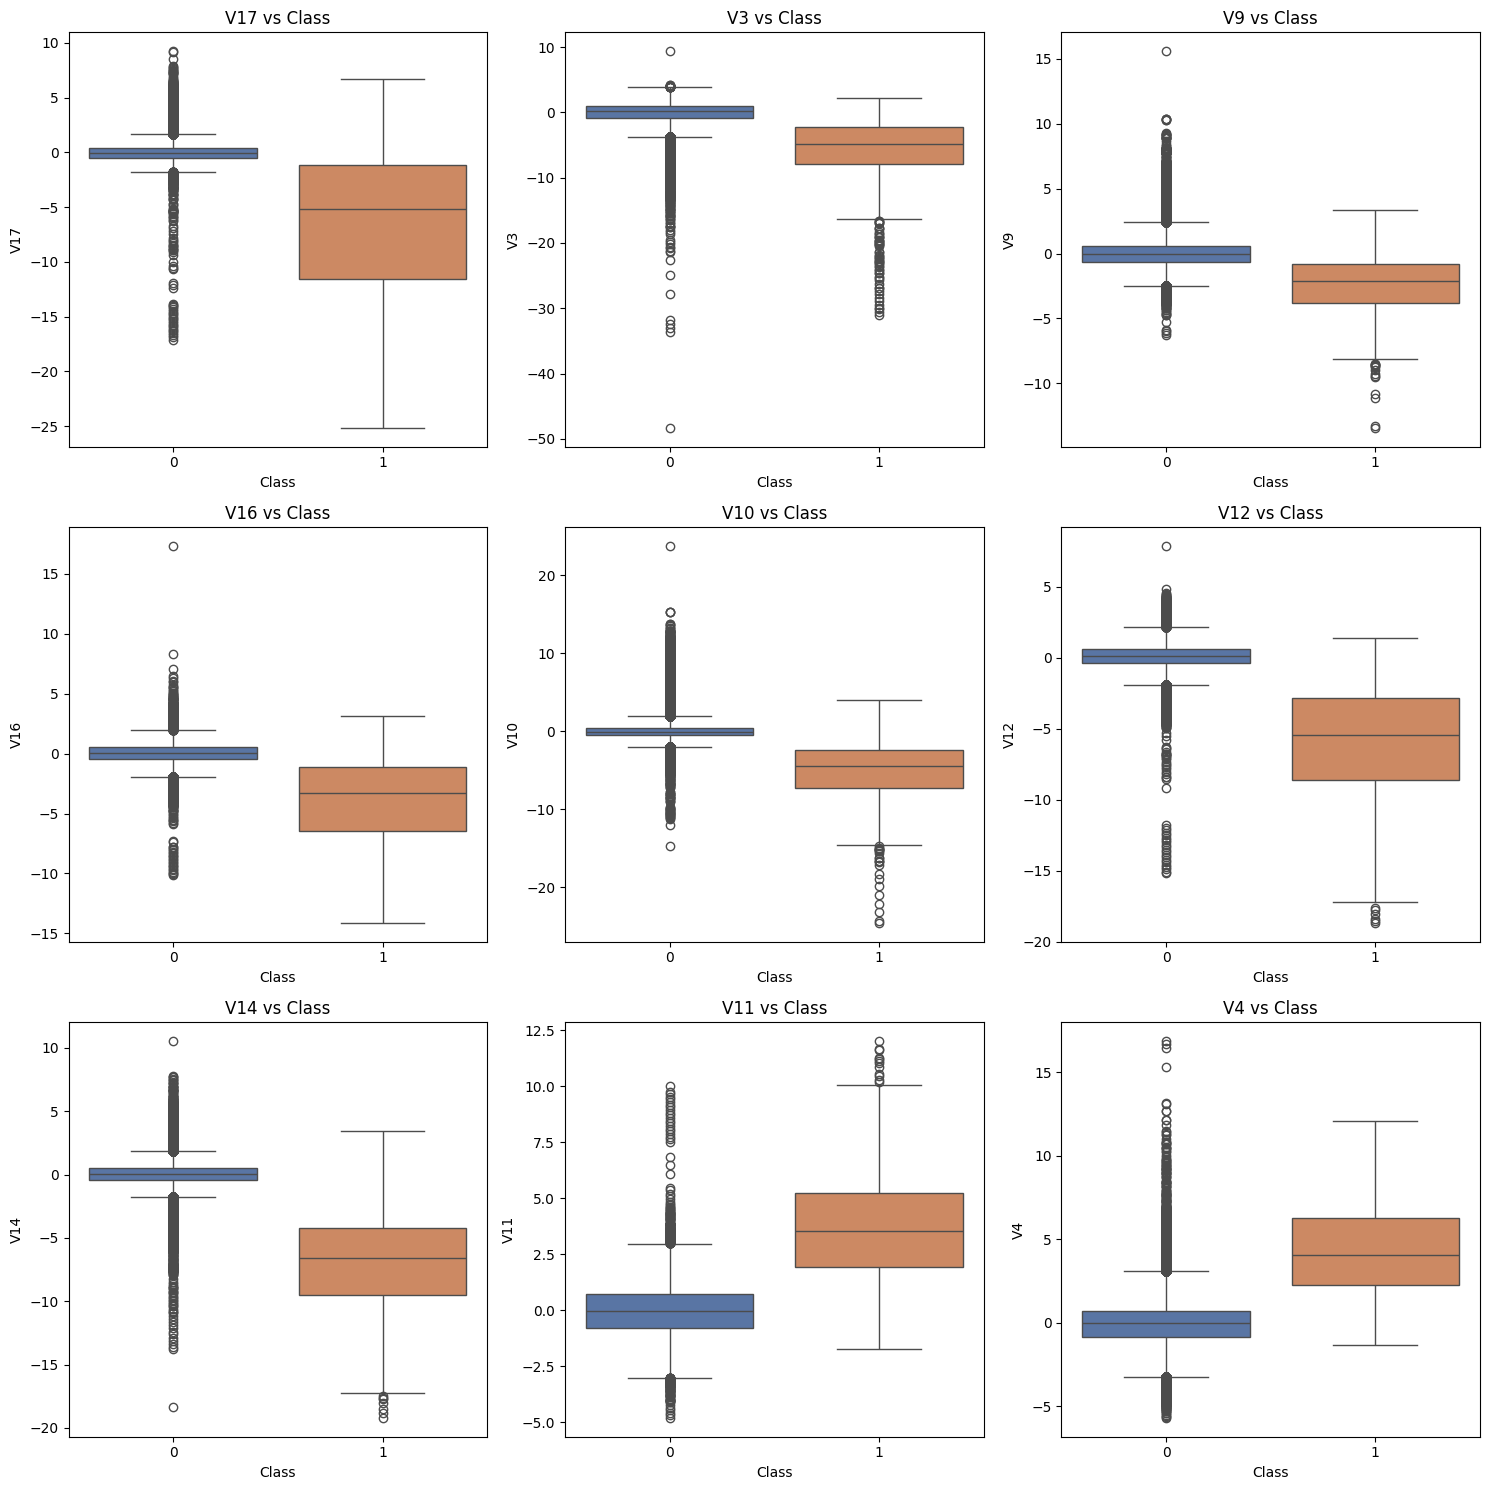

In [ ]:
# A closer look at distribution of those significant correlation features
columns = ['V17', 'V3', 'V9', 'V16', 'V10', 'V12', 'V14', 'V11', 'V4']

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.boxplot(x='Class', y=col, data=df,palette=colors, ax=axes[i])
    axes[i].set_title(f'{col} vs Class')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


**Check if frauds are outliers**

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit on non-fraud data
iso = IsolationForest(contamination=0.01, random_state=RANDOM_STATE)
iso.fit(df[df['Class'] == 0].iloc[:, 1:28])

# Predict on frauds
fraud_outliers = iso.predict(df[df['Class'] == 1].iloc[:, 1:28])
print(f'Frauds flagged as outliers: {sum(fraud_outliers == -1)} / {len(fraud_outliers)}')

Frauds flagged as outliers: 279 / 473


Most frauds transactions are flagged as outliers. This is important to keep in mind when building predictive models.

#**III. Model Development**

In [ ]:
# Data preparation

# Time-based cyclical encoding
df['Time_sin'] = np.sin(2 * np.pi * df['Time']/(24*3600))
df['Time_cos'] = np.cos(2 * np.pi * df['Time']/(24*3600))
# Scaled Amount
df['amount_scaled'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

# Final features
X = df.drop(['Time', 'Amount', 'Class'], axis=1)
y = df['Class']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# Only on training data
smote = SMOTE(sampling_strategy={1: 2000}, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy={0: 20000}, random_state=RANDOM_STATE)

X_train_res, y_train_res = Pipeline([
    ('smote', smote),
    ('under', under)
]).fit_resample(X_train, y_train)

In [ ]:
# Custom F2 score
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [ ]:
# Neural Network builder
def create_nn_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name='pr_auc', curve='PR')]
    )
    return model

In [ ]:
# Threshold optimization
def optimize_threshold(model, X_val, y_val):
    y_proba = model.predict(X_val).ravel() if isinstance(model, Sequential) \
              else model.predict_proba(X_val)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

    # Find threshold for 90% recall
    target_recall = 0.90
    optimal_idx = np.argmin(np.abs(recall - target_recall))
    return thresholds[optimal_idx]

In [ ]:
# Model configurations
MODELS = {
    'RandomForest': RandomForestClassifier(
        class_weight='balanced_subsample',
        n_estimators=500,
        max_depth=10,
        max_features='sqrt',
        bootstrap=True,
        random_state=RANDOM_STATE
    ),
    'XGBoost': XGBClassifier(
        scale_pos_weight=283253/473,
        objective='binary:logistic',
        eval_metric='aucpr',
        subsample=0.7,
        colsample_bytree=0.8,
        max_depth=6,
        learning_rate=0.05,
        n_estimators=1000,
        random_state=RANDOM_STATE
    ),
    'CatBoost': CatBoostClassifier(
        auto_class_weights='Balanced',
        iterations=1500,
        od_type='Iter',
        od_wait=100,
        depth=6,
        learning_rate=0.05,
        silent=True,
        random_state=RANDOM_STATE
    ),
    'NeuralNetwork': create_nn_model((X_train_res.shape[1],))
}

In [ ]:
# Create validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_res, y_train_res,
    test_size=0.2,
    stratify=y_train_res,
    random_state=RANDOM_STATE
)

# Training Loop
results = {}
for name, model in MODELS.items():
    print(f"\n{'='*30}\nTraining {name}\n{'='*30}")

    if 'NeuralNetwork' in name:
        history = model.fit(
            X_train_final, y_train_final,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=1024,
            class_weight={0: 1, 1: 50},
            callbacks=[
                EarlyStopping(patience=15, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=5)
            ],
            verbose=0
        )
    else:
        model.fit(X_train_final, y_train_final)

    # Threshold optimization
    optimal_threshold = optimize_threshold(model, X_val, y_val)

    # Predict with optimal threshold
    if 'NeuralNetwork' in name:
        test_proba = model.predict(X_test).ravel()
    else:
        test_proba = model.predict_proba(X_test)[:, 1]

    y_pred = (test_proba >= optimal_threshold).astype(int)

    # Store metrics
    results[name] = {
        'threshold': optimal_threshold,
        'pr_auc': average_precision_score(y_test, test_proba),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f2': fbeta_score(y_test, y_pred, beta=2)
    }


Training RandomForest

Training XGBoost

Training CatBoost

Training NeuralNetwork
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


#**IV. Evaluation**

In [ ]:
def evaluate_model(model, X_test, y_test, model_name='Model', threshold=None):
    """Evaluate model with optimal threshold selection and visualization"""

    # Get predictions
    if isinstance(model, Sequential):
        y_proba = model.predict(X_test).ravel()
    else:
        y_proba = model.predict_proba(X_test)[:, 1]

    # Find optimal threshold using precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # Target 90% recall
    target_recall = 0.90
    optimal_idx = np.argmin(np.abs(recall - target_recall))
    optimal_threshold = thresholds[optimal_idx]

    # Use provided threshold or optimal threshold
    final_threshold = threshold if threshold else optimal_threshold
    y_pred = (y_proba >= final_threshold).astype(int)

    # Calculate metrics
    metrics = {
        'PR-AUC': average_precision_score(y_test, y_proba),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'F2': fbeta_score(y_test, y_pred, beta=2),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'MCC': matthews_corrcoef(y_test, y_pred),
        'Threshold': final_threshold,
        'Avg_Precision': average_precision_score(y_test, y_proba)
    }

    # Custom cost function
    fp_cost = 10  # Cost per false positive
    fn_cost = 100  # Cost per false negative
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    metrics['Cost'] = (fp * fp_cost) + (fn * fn_cost)

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax[0].plot(fpr, tpr, label=f'ROC AUC = {metrics["ROC-AUC"]:.2f}')
    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set_title('ROC Curve')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')

    # Precision-Recall Curve
    ax[1].plot(recall, precision, label=f'PR AUC = {metrics["PR-AUC"]:.2f}')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        normalize='true',
        ax=ax[2],
        values_format='.2%',
        colorbar=False
    )
    ax[2].set_title('Normalized Confusion Matrix')

    plt.suptitle(f'{model_name} Evaluation (Threshold: {final_threshold:.3f})')
    plt.tight_layout()
    plt.show()

    # Classification report
    print(f"\n{classification_report(y_test, y_pred, target_names=['Legit', 'Fraud'])}")
    print(f"Matthews Correlation Coefficient: {metrics['MCC']:.3f}")
    print(f"Estimated Operational Cost: ${metrics['Cost']:,.2f}")

    return metrics

We will concentrate on following metrics with specific reasons:
- Imbalanced dataset: **PR-AUC** (instead of ROC-AUC)
- Cost of missing fraud: **F2 Score**, Requirement for 90% **Recall** (missing fraudulent transactions (false negatives) is much more costly than mistakenly flagging legitimate transactions as fraud (false positives))


Evaluating RandomForest


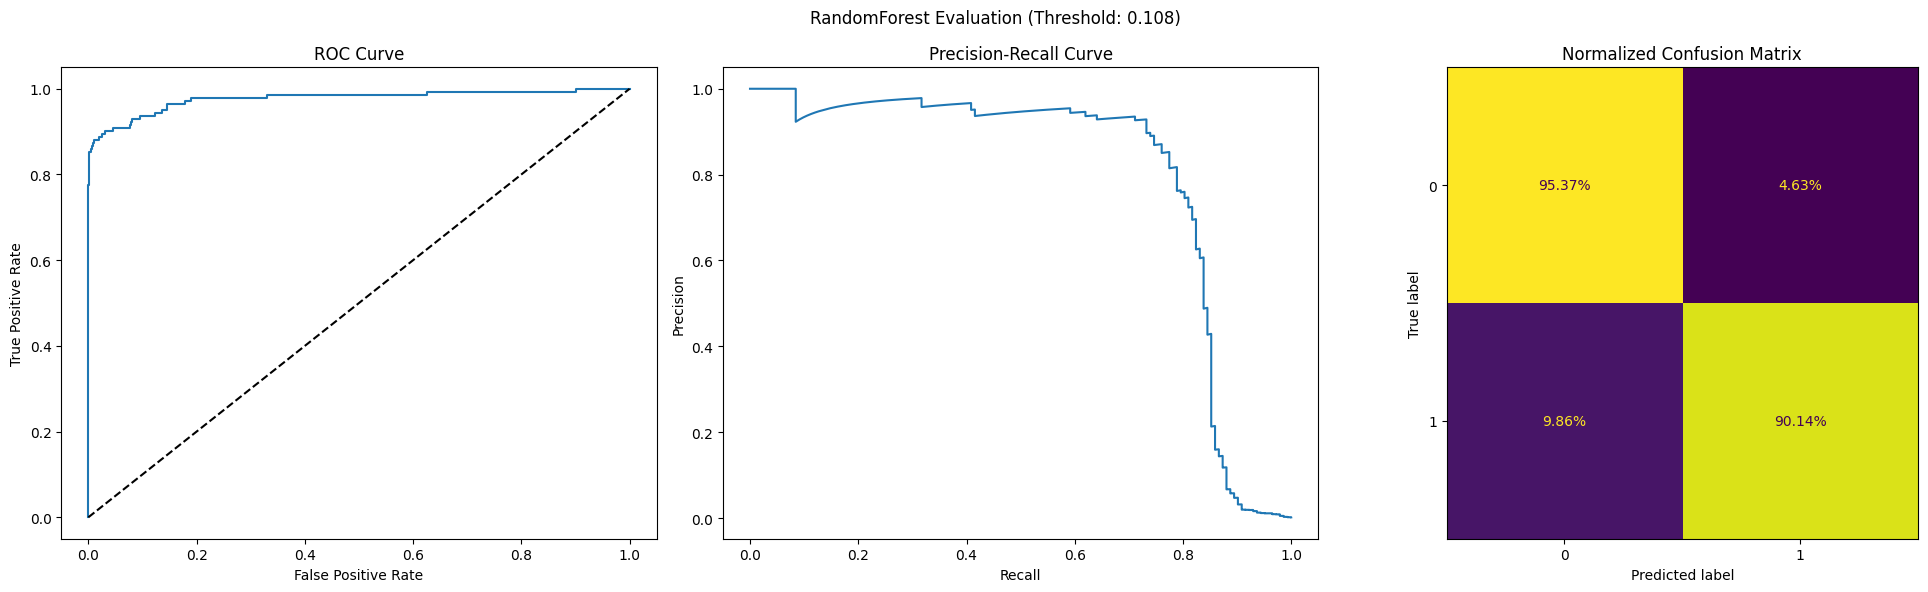


              precision    recall  f1-score   support

       Legit       1.00      0.95      0.98     84976
       Fraud       0.03      0.90      0.06       142

    accuracy                           0.95     85118
   macro avg       0.52      0.93      0.52     85118
weighted avg       1.00      0.95      0.97     85118

Matthews Correlation Coefficient: 0.164
Estimated Operational Cost: $40,710.00

Top 10 Features for RandomForest:
V14    0.188506
V10    0.133485
V12    0.116138
V4     0.102796
V17    0.086831
V11    0.066521
V3     0.046164
V16    0.041848
V7     0.029823
V2     0.023215
dtype: float64

Evaluating XGBoost


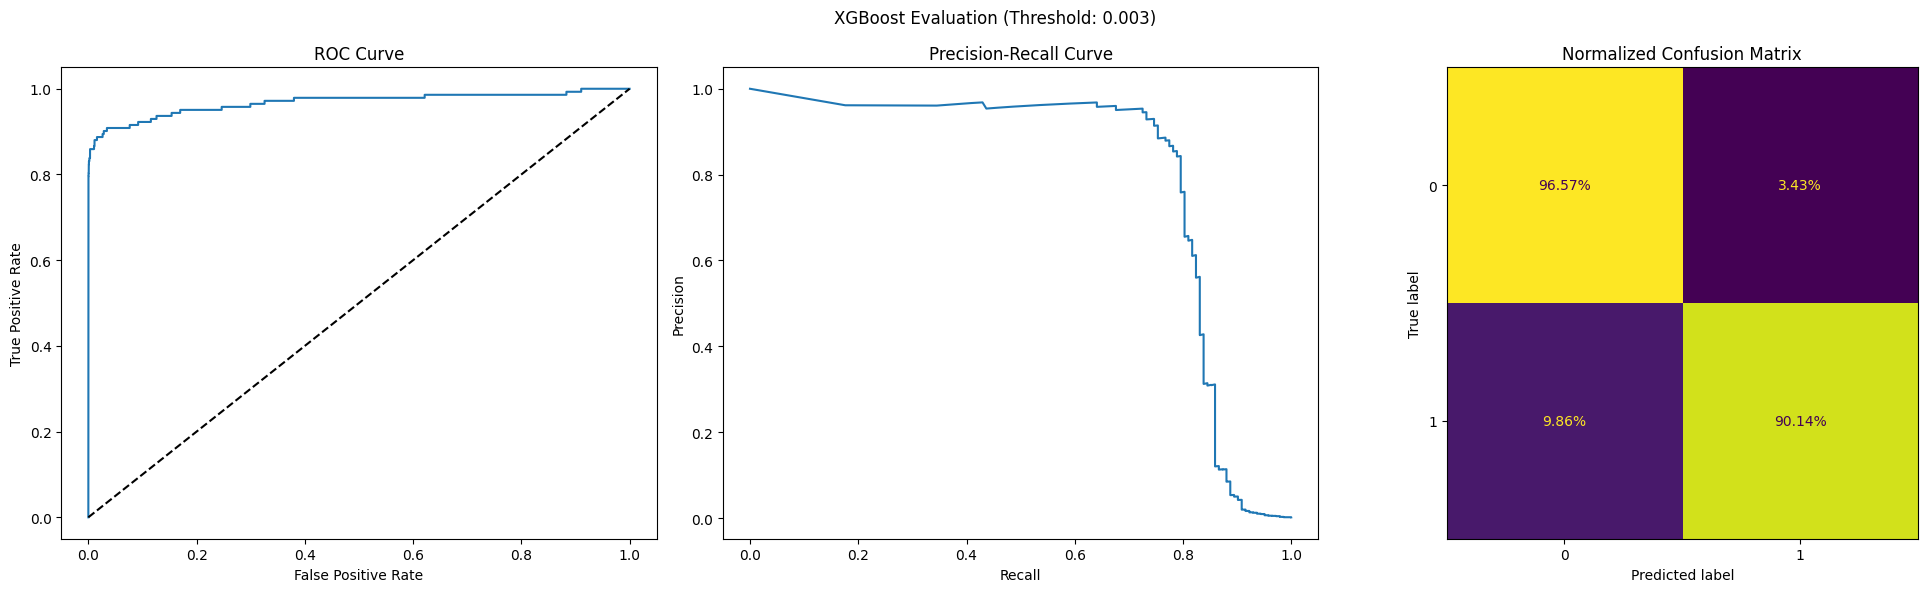


              precision    recall  f1-score   support

       Legit       1.00      0.97      0.98     84976
       Fraud       0.04      0.90      0.08       142

    accuracy                           0.97     85118
   macro avg       0.52      0.93      0.53     85118
weighted avg       1.00      0.97      0.98     85118

Matthews Correlation Coefficient: 0.191
Estimated Operational Cost: $30,550.00

Top 10 Features for XGBoost:
V4     0.167974
V14    0.116452
V10    0.062223
V8     0.049496
V12    0.048908
V13    0.037349
V15    0.037274
V18    0.035363
V16    0.033499
V3     0.029358
dtype: float32

Evaluating CatBoost


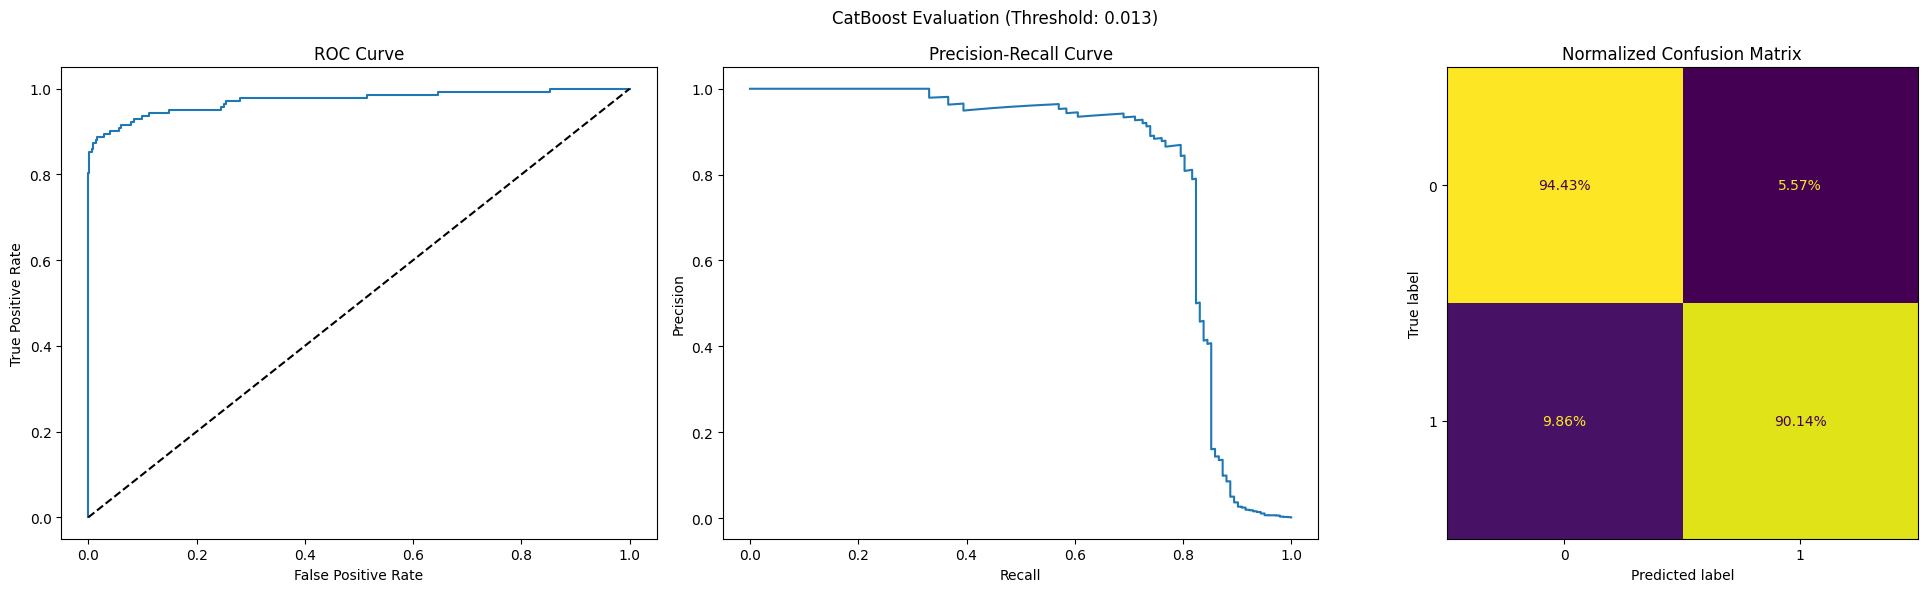


              precision    recall  f1-score   support

       Legit       1.00      0.94      0.97     84976
       Fraud       0.03      0.90      0.05       142

    accuracy                           0.94     85118
   macro avg       0.51      0.92      0.51     85118
weighted avg       1.00      0.94      0.97     85118

Matthews Correlation Coefficient: 0.149
Estimated Operational Cost: $48,760.00

Top 10 Features for CatBoost:
V14    12.032975
V4     11.445856
V17     5.477709
V10     4.843681
V12     4.654993
V1      4.297877
V8      3.639391
V3      3.572242
V11     3.517885
V5      3.396850
dtype: float64

Evaluating NeuralNetwork
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


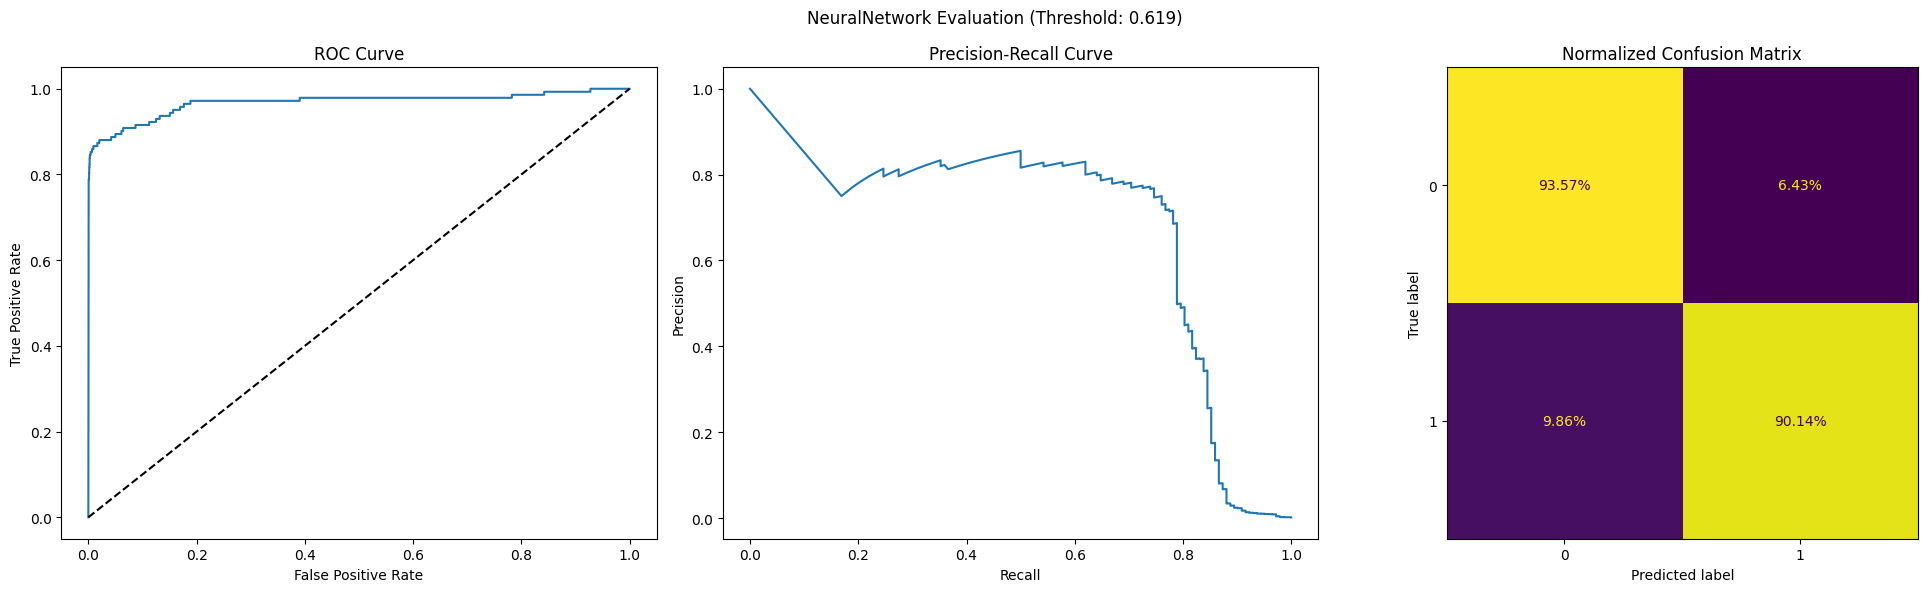


              precision    recall  f1-score   support

       Legit       1.00      0.94      0.97     84976
       Fraud       0.02      0.90      0.04       142

    accuracy                           0.94     85118
   macro avg       0.51      0.92      0.51     85118
weighted avg       1.00      0.94      0.97     85118

Matthews Correlation Coefficient: 0.138
Estimated Operational Cost: $56,070.00

Model Performance Comparison:


,PR-AUC,ROC-AUC,Recall,Precision,F2,MCC,Cost,Threshold
RandomForest,0.797968,0.976960,0.901408,0.031535,0.138319,0.163766,"$40,710.00",0.108
XGBoost,0.797548,0.967905,0.901408,0.042064,0.177236,0.190593,"$30,550.00",0.003
CatBoost,0.810793,0.973109,0.901408,0.026316,0.117820,0.148685,"$48,760.00",0.013
NeuralNetwork,0.656775,0.967955,0.901408,0.022878,0.103846,0.137851,"$56,070.00",0.619


In [ ]:
# Evaluate all models
results = {}
for name, model in MODELS.items():
    print(f"\n{'='*50}\nEvaluating {name}\n{'='*50}")
    results[name] = evaluate_model(model, X_test, y_test, name)

    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=X.columns)
        print(f"\nTop 10 Features for {name}:")
        print(importance.sort_values(ascending=False).head(10))

# Compare model performance
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df[[
    'PR-AUC', 'ROC-AUC', 'Recall', 'Precision',
    'F2', 'MCC', 'Cost', 'Threshold'
]]

print("\nModel Performance Comparison:")
display(metrics_df.style
        .background_gradient(cmap='viridis', subset=['PR-AUC', 'Recall', 'F2'])
        .format({'Cost': '${:,.2f}', 'Threshold': '{:.3f}'}))

**Model Selection**

After evaluation process, I recommend using XGBoost because:
1. Best cost efficiency (lowest financial impact of errors).
2. Highest F2 score
3. Highest MCC
4. Pretty good PR-AUC (just below the best 0.02)

**Noticable consideration about Threshold**

XGBoost uses a very low threshold (0.003), which flags more transactions as fraudulent. While this increases recall (good) and lowers cost (good), it risks more false positives. However:

- The low cost suggests false positives are financially manageable.

- Precision (0.042) is still the highest among all models, indicating better-than-average fraud confirmation.

In [ ]:
# Get feature importance
feature_importances = {}

# Only tree-based models
for name in ['RandomForest', 'XGBoost', 'CatBoost']:
    if hasattr(MODELS[name], 'feature_importances_'):
        importances = MODELS[name].feature_importances_
        # Normalize to 0-1 scale
        normalized = (importances - importances.min()) / (importances.max() - importances.min())
        feature_importances[name] = pd.Series(normalized, index=X.columns)

In [ ]:
# Create top 10 Dataframe
top_features = {}

for model in feature_importances:
    # Get top 10
    top = (feature_importances[model]
           .sort_values(ascending=False)
           .head(10)
           .reset_index()
           .rename(columns={'index': 'Feature', 0: 'Importance'}))

    # Store in dictionary
    top_features[model] = top.set_index('Feature')['Importance']

# Create combined DataFrame
importance_df = pd.concat(top_features, axis=1)
importance_df = importance_df.loc[~importance_df.index.duplicated()].fillna(0)

# Normalize across models for comparison
importance_df = importance_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

importance_df['Average'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values('Average', ascending=False).head(10)
importance_df = importance_df.drop('Average', axis=1)

print("\nTop 10 Fraud Detection Features:")
display(importance_df.style.background_gradient(cmap='Blues', axis=0))


Top 10 Fraud Detection Features:


,RandomForest,XGBoost,CatBoost
Feature,,,
V14,1.000000,0.678333,1.000000
V4,0.538314,1.000000,0.946321
V10,0.703624,0.339761,0.342693
V12,0.610183,0.256635,0.325441
V17,0.452320,0.000000,0.400661
V3,0.233263,0.134575,0.226447
V11,0.342917,0.000000,0.221477
V8,0.000000,0.260301,0.232586
V16,0.210016,0.160431,0.000000


V14 and V4 are the most important features, they are also the features with strongest correlation with Class columm.